# Trabalho final - Tópicos 3

**Universidade Federal de Santa Catarina (UFSC)**

---
Autores:  
1. Felipe Henrique Verones Pereira dos Santos
2. Gabriel Bernardes de Carvalho
---

[Dataset utilizado](https://www.kaggle.com/niteshyadav3103/concrete-compressive-strength)


Explicação das colunas do dataset:

Atributo           | Unidade   | Nome na coleção               | Sigla
---------          | --------- | ---------                     | -------
Cimento            | kg/m³     | Cement                        | $c$  
Escória Alto Forno | kg/m³     | Blast Furnace Slag            | $bfs$
Cinza Volante      | kg/m³     | Fly Ash                       | $fa$
Água               | kg/m³     | Water                         | $w$
Superplastificante | kg/m³     | Superplasticizer              | $sp$
Agregado Graúdo    | kg/m³     | Coarse Aggregate              | $cag$
Agregado Miúdo     | kg/m³     | Fine Aggregate                | $fag$
Idade              | dias      | Age                           | $t$  
f_ck               | MPa       | Concrete compressive strength | $f_ck$

## Dependências

### Instalações de bibliotecas

In [1]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importação de bibliotecas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

## Coleta de dados

In [3]:
data_frame = pd.read_csv('Concrete Compressive Strength.csv', delimiter=',')
data_frame.columns = ['c', 'bd', 'fa', 'w', 'sp', 'cag', 'fag', 't', 'fck']
data_frame

,c,bd,fa,w,sp,cag,fag,t,fck
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


## Pré-processamento

### Limpeza

In [4]:
pre_processed_data_frame = data_frame.copy()
pre_processed_data_frame = data_frame.drop_duplicates()

# Máxima idade requerida por norma
pre_processed_data_frame = pre_processed_data_frame.drop(pre_processed_data_frame[pre_processed_data_frame.t > 28].index)

# Relação água cimento
pre_processed_data_frame['w / c'] = pre_processed_data_frame['w'] / pre_processed_data_frame['c']
pre_processed_data_frame = pre_processed_data_frame.drop(columns = ['w'])

# Mesclar aditivos com relação com resistência
pre_processed_data_frame['add'] = pre_processed_data_frame['bd'] + pre_processed_data_frame['fa']
pre_processed_data_frame = pre_processed_data_frame.drop(columns = ['bd', 'fa'])

# Eliminar aditivo sem relação com resistência
pre_processed_data_frame = pre_processed_data_frame.drop(columns = 'sp')

pre_processed_data_frame.reset_index(drop=True, inplace=True)
pre_processed_data_frame = pre_processed_data_frame.loc[:, ["c", "cag", "fag", "w / c", "add", "t", "fck" ]]
pre_processed_data_frame

,c,cag,fag,w / c,add,t,fck
0,540.0,1040.0,676.0,0.300000,0.0,28,79.986111
1,540.0,1055.0,676.0,0.300000,0.0,28,61.887366
2,380.0,932.0,594.0,0.600000,95.0,28,36.447770
3,266.0,932.0,670.0,0.857143,114.0,28,45.854291
4,475.0,932.0,594.0,0.480000,0.0,28,39.289790
...,...,...,...,...,...,...,...
729,276.4,870.1,768.3,0.649783,206.3,28,44.284354
730,322.2,817.9,813.4,0.608318,115.6,28,31.178794
731,148.5,892.4,780.0,1.297643,248.0,28,23.696601
732,159.1,989.6,788.9,1.103708,186.7,28,32.768036


### Normalização

In [5]:
scales = pre_processed_data_frame.describe().loc[['mean', 'std']]
data_frame_normalized = pre_processed_data_frame.copy()
for column in data_frame_normalized:
  if column != 'fck':
    data_frame_normalized[column] = data_frame_normalized[column].apply(lambda x: (x - scales[column][0])/ scales[column][1])    
data_frame_normalized

,c,cag,fag,w / c,add,t,fck
0,2.536992,0.847695,-1.276916,-1.448013,-1.434365,0.840365,79.986111
1,2.536992,1.033130,-1.276916,-1.448013,-1.434365,0.840365,61.887366
2,1.011198,-0.487436,-2.359903,-0.529878,-0.416191,0.840365,36.447770
3,-0.075930,-0.487436,-1.356159,0.257094,-0.212556,0.840365,45.854291
4,1.917139,-0.487436,-2.359903,-0.897132,-1.434365,0.840365,39.289790
...,...,...,...,...,...,...,...
729,0.023247,-1.252664,-0.057896,-0.377520,0.776682,0.840365,44.284354
730,0.460005,-1.897977,0.537747,-0.504422,-0.195408,0.840365,31.178794
731,-1.196435,-0.976984,0.096628,1.605222,1.223607,0.840365,23.696601
732,-1.095351,0.224634,0.214172,1.011695,0.566616,0.840365,32.768036


## Visualização de dados pré-processados

### Descrição dos dados

In [6]:
pre_processed_data_frame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
c,734.0,273.962289,104.863422,102.000000,181.900000,259.950000,337.900000,540.000000
cag,734.0,971.429142,80.890935,801.000000,923.050000,968.000000,1036.750000,1145.000000
fag,734.0,772.683665,75.716540,594.000000,728.225000,778.200000,819.250000,992.600000
w / c,734.0,0.773138,0.326750,0.266893,0.545723,0.704323,0.991542,1.882353
add,734.0,133.832343,93.304213,0.000000,94.610000,133.850000,189.000000,382.000000
t,734.0,18.859673,10.876621,1.000000,7.000000,28.000000,28.000000,28.000000
fck,734.0,30.665323,14.995086,2.331808,19.128822,29.316520,39.391488,81.751169


### Correlação

<function matplotlib.pyplot.show(close=None, block=None)>

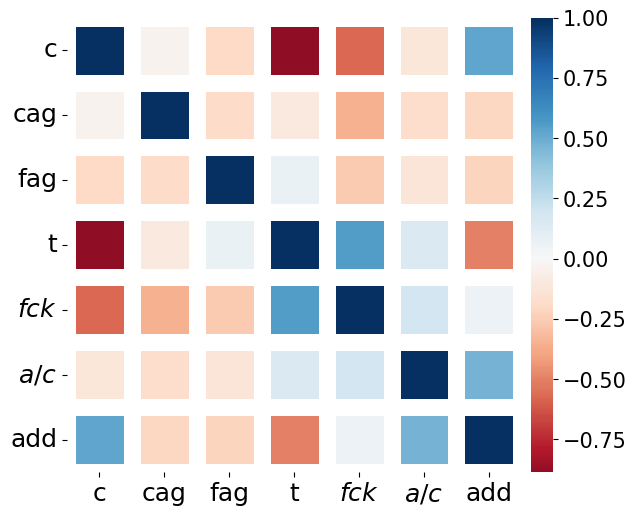

In [7]:
# Correlação direta entre dados
correlation = pre_processed_data_frame.corr()

_, ax = plt.subplots(1, 1, figsize = (0.30 / 0.0254, 0.15 / 0.0254))
correlation_heatmap = sns.heatmap(
  correlation,
  ax = ax,
  cmap = 'RdBu',
  center = False,
  annot = False,
  annot_kws = {
    'size': 12,
    'color': '#FFFFFF'
  },
  linewidths = 12,
  linecolor = '#FFFFFF',
  xticklabels = ['c', 'cag', 'fag', 't', '$f{ck}$', '$a / c$', 'add'],
  yticklabels = ['c', 'cag', 'fag', 't', '$f{ck}$', '$a / c$', 'add'],
  cbar = True,
  square = True,
  cbar_kws = {
    'orientation': 'vertical',
    'shrink': 1,
    'pad': 0.01,
  }
)
ax.tick_params(axis = 'x', labelsize = 18, colors = '#000000')
ax.tick_params(axis = 'y', labelsize = 18, colors = '#000000')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0) 
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0) 

cbar = correlation_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize = 15)

# Save and show
plt.savefig('Correlation Heatmap.svg', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.show

## Processamento

### Organização

In [8]:
features = data_frame_normalized.drop(columns = 'fck')
meta = pd.DataFrame(data_frame_normalized['fck'], columns = ['fck'])

In [9]:
features

,c,cag,fag,w / c,add,t
0,2.536992,0.847695,-1.276916,-1.448013,-1.434365,0.840365
1,2.536992,1.033130,-1.276916,-1.448013,-1.434365,0.840365
2,1.011198,-0.487436,-2.359903,-0.529878,-0.416191,0.840365
3,-0.075930,-0.487436,-1.356159,0.257094,-0.212556,0.840365
4,1.917139,-0.487436,-2.359903,-0.897132,-1.434365,0.840365
...,...,...,...,...,...,...
729,0.023247,-1.252664,-0.057896,-0.377520,0.776682,0.840365
730,0.460005,-1.897977,0.537747,-0.504422,-0.195408,0.840365
731,-1.196435,-0.976984,0.096628,1.605222,1.223607,0.840365
732,-1.095351,0.224634,0.214172,1.011695,0.566616,0.840365


In [10]:
meta

,fck
0,79.986111
1,61.887366
2,36.447770
3,45.854291
4,39.289790
...,...
729,44.284354
730,31.178794
731,23.696601
732,32.768036


Modelo: Regressão Linear - 1 
 r² acurácia treino: 77.469 
 r² acurácia teste: 79.381


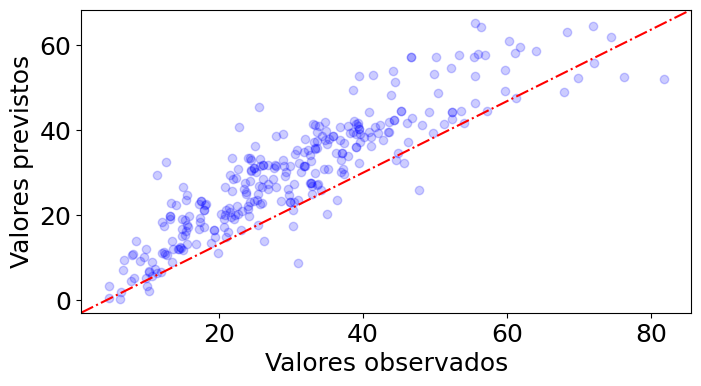

Modelo: Regressão Linear - 2 
 r² acurácia treino: 82.505 
 r² acurácia teste: 83.196


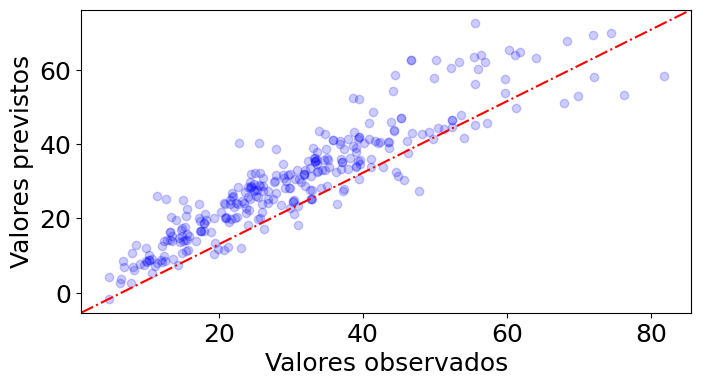

Modelo: Regressão Linear - 3 
 r² acurácia treino: 88.635 
 r² acurácia teste: 82.202


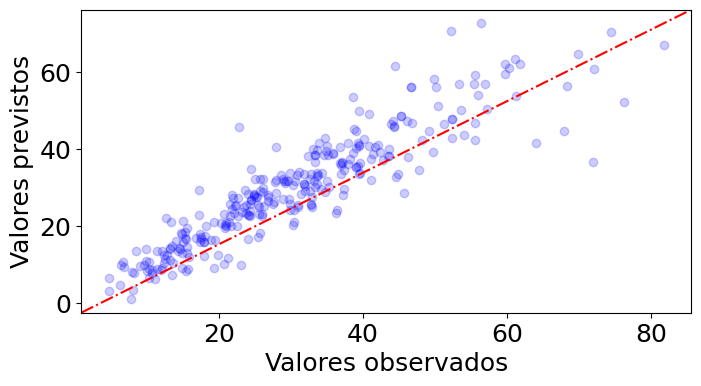

Modelo: Regressão Ridge Linear - 1 
 r² acurácia treino: 77.455 
 r² acurácia teste: 79.552


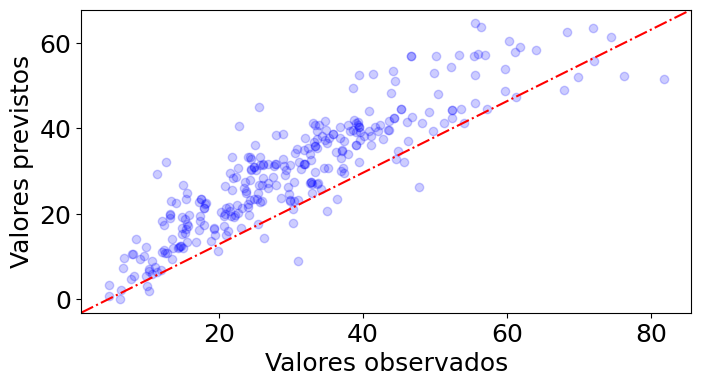

Modelo: Regressão Ridge Linear - 2 
 r² acurácia treino: 82.409 
 r² acurácia teste: 83.392


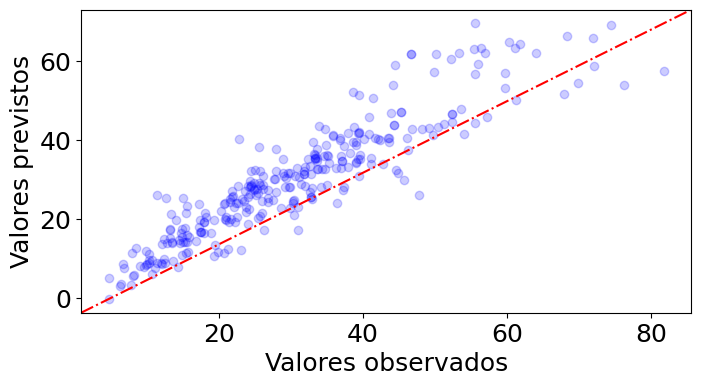

Modelo: Regressão Ridge Linear - 3 
 r² acurácia treino: 87.767 
 r² acurácia teste: 84.662


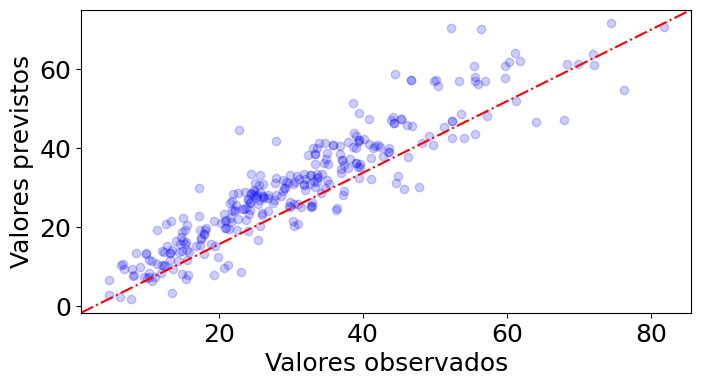

Modelo: Árvore de decisão de profundidade 2 
 r² acurácia treino: 50.950 
 r² acurácia teste: 55.270


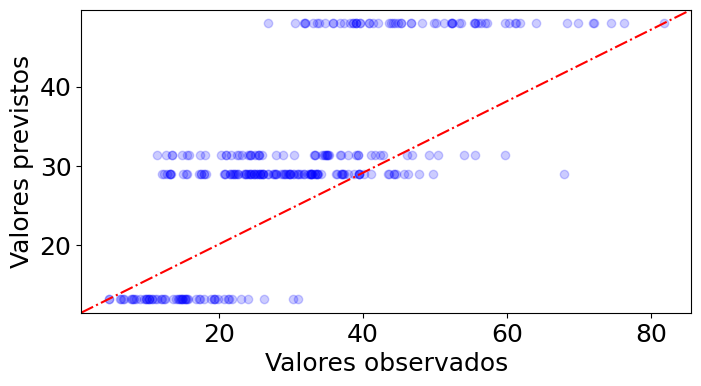

Modelo: Árvore de decisão de profundidade 5 
 r² acurácia treino: 83.355 
 r² acurácia teste: 72.365


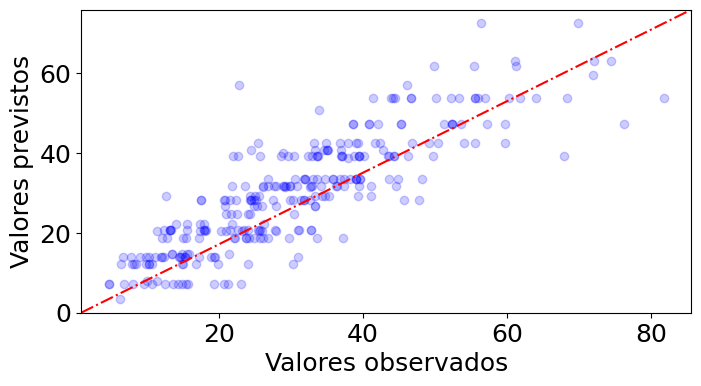

Modelo: Árvore de decisão de profundidade 10 
 r² acurácia treino: 99.135 
 r² acurácia teste: 73.490


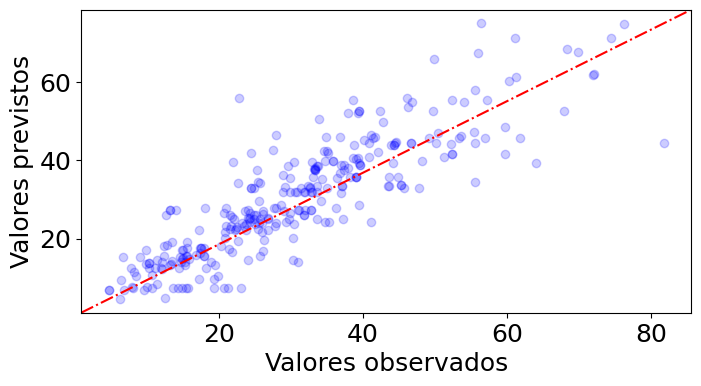

Modelo: Árvore de decisão de profundidade 20 
 r² acurácia treino: 99.888 
 r² acurácia teste: 73.024


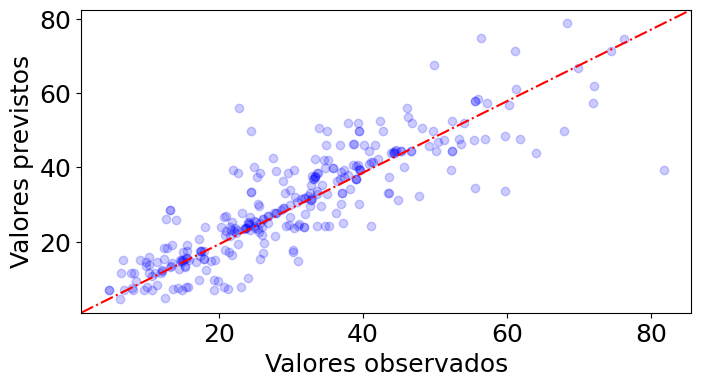

In [11]:
models = [
  {
    'algorithm': LinearRegression(),
    'method': 'Regressão Linear - 1',
    'type': 'regression',
    'options': 1
  },
  {
    'algorithm': LinearRegression(),
    'method': 'Regressão Linear - 2',
    'type': 'regression',
    'options': 2
  },
  {
    'algorithm': LinearRegression(),
    'method': 'Regressão Linear - 3',
    'type': 'regression',
    'options': 3
  },
  {
    'algorithm': Ridge(),
    'method': 'Regressão Ridge Linear - 1',
    'type': 'regression',
    'options': 1
  },
  {
    'algorithm': Ridge(),
    'method': 'Regressão Ridge Linear - 2',
    'type': 'regression',
    'options': 2
  },
  {
    'algorithm': Ridge(),
    'method': 'Regressão Ridge Linear - 3',
    'type': 'regression',
    'options': 3
  },
  {
    'algorithm': DecisionTreeRegressor(max_depth = 2),
    'method': 'Árvore de decisão de profundidade 2',
    'type': 'tree',
    'options': 2
  },
  {
    'algorithm': DecisionTreeRegressor(max_depth = 5),
    'method': 'Árvore de decisão de profundidade 5',
    'type': 'tree',
    'options': 5
  },
  {
    'algorithm': DecisionTreeRegressor(max_depth = 10),
    'method': 'Árvore de decisão de profundidade 10',
    'type': 'tree',
    'options': 10
  },
  {
    'algorithm': DecisionTreeRegressor(max_depth = 20),
    'method': 'Árvore de decisão de profundidade 20',
    'type': 'tree',
    'options': 20
  }
]

features_train, features_test, meta_train, meta_test  = train_test_split(features, meta, train_size = 0.60, shuffle = True)

for model in models:
  if (model['type'] == 'regression'):
    pipeline = make_pipeline(PolynomialFeatures(degree = model['options']), model['algorithm'])
  else:
    pipeline = model['algorithm']

  pipeline.fit(features_train, meta_train)

  feature_predict_train = pipeline.predict(features_train)
  r2_train = r2_score(meta_train, feature_predict_train)

  feature_predict_test = pipeline.predict(features_test)
  r2_test = r2_score(meta_test, feature_predict_test)

  model['r2_train'] = r2_train
  model['r2_test'] = r2_test
  
  print('Modelo: ' + model['method'] + ' \n ' + 'r² acurácia treino: %.3f \n r² acurácia teste: %.3f' % (r2_train * 100, r2_test * 100))
  
  _, ax = plt.subplots(1, 1, figsize = (0.20 / 0.0254, 0.10 / 0.0254))
  ax.scatter(meta_test, feature_predict_test, marker = 'o', alpha = 0.2, color = 'b')
  ax.set_xlabel('Valores observados', fontsize = 18)
  ax.set_ylabel('Valores previstos', fontsize = 18)
  ax.tick_params(axis = 'x', labelsize = 18, colors = '#000000')
  ax.tick_params(axis = 'y', labelsize = 18, colors = '#000000')
  ax.plot([0, 1], [0, 1], transform = ax.transAxes, color = 'r', linestyle = '-.')
  plt.savefig(model['method'] + '.svg', dpi = 600, bbox_inches = 'tight', transparent = True)
  plt.show()

## Avaliação

### Melhores modelos

In [14]:
models = sorted(models, key = lambda model: model['r2_test'], reverse =  True)
best_models = []
for m in models:
  best_models.append({
    'method': m['method'],
    'r2_test': m['r2_test'],
  })
best_models

[{'method': 'Regressão Ridge Linear - 3', 'r2_test': 0.846616598356737},
 {'method': 'Regressão Ridge Linear - 2', 'r2_test': 0.8339235602428882},
 {'method': 'Regressão Linear - 2', 'r2_test': 0.8319571731954349},
 {'method': 'Regressão Linear - 3', 'r2_test': 0.8220220222882993},
 {'method': 'Regressão Ridge Linear - 1', 'r2_test': 0.79551982079228},
 {'method': 'Regressão Linear - 1', 'r2_test': 0.7938146056830293},
 {'method': 'Árvore de decisão de profundidade 10',
  'r2_test': 0.7348993748968702},
 {'method': 'Árvore de decisão de profundidade 20',
  'r2_test': 0.7302398768092944},
 {'method': 'Árvore de decisão de profundidade 5',
  'r2_test': 0.7236480100016933},
 {'method': 'Árvore de decisão de profundidade 2',
  'r2_test': 0.5526973678266676}]